In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
from imutils import paths
import skimage.measure
import cv2

class DataGenerator(Sequence):
    def __init__(self, data_dir, mode='fit', batch_size=8,dim=(256, 256),scale=0.5, channels=3, shuffle=True):
        self.list_image = list(paths.list_images(data_dir))
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.scale=scale
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
   
    # phương thức này sẽ được tự đông gọi khi kết thúc 1 epoch, để đảo ngẫu nhiên lại thứ tự các ảnh khi train
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_image))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    # trả về số lượng batch
    def __len__(self):
        return int(np.floor(len(self.list_image) / self.batch_size))
    
    # trả về batch tương ứng với index
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        if self.mode == 'fit':
            # các train data của batch đó sẽ được lưu vào biến X
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            # nếu model đang train thì cần tạo thêm dữ liệu về ảnh gốc của batch đó
            y = np.empty((self.batch_size, *self.dim, self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                y[i]=img

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img

                # img = cv2.imread(self.list_image[ID])
                # img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                # y[i] = img
            return X,y
                
                
        # nếu model đang predict thì không cần tạo thêm dữ liệu về ảnh gốc của batch đó
        elif self.mode == 'predict':
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            

In [ ]:
train_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Train')
val_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Valid')

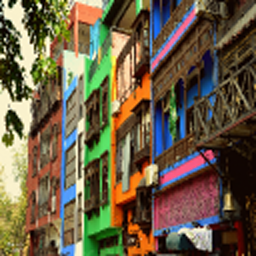

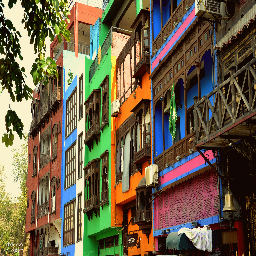

In [ ]:
from google.colab.patches import cv2_imshow

img_lr= train_data_generator[10][0][0]
img_hr=train_data_generator[10][1][0]
cv2_imshow(img_lr)
cv2_imshow(img_hr)

In [ ]:
from keras import backend as K

def PSNR(y_true,y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=255)

In [ ]:
from keras.models import Model
from keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, Convolution2DTranspose
from keras.utils.np_utils import to_categorical
import keras.callbacks as callbacks



def residual_block(ip, id):
    init = ip

    x = Convolution2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_1')(ip)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_1")(x, training=True)
    x = Activation('relu', name="sr_res_activation_" + str(id) + "_1")(x)

    x = Convolution2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_2')(x)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_2")(x, training=True)

    m = Add(name="sr_res_merge_" + str(id))([x, init])

    return m

def upscale_block(ip, id):
    init = ip


    # x = Convolution2D(256, (3, 3), activation="relu", padding='same', name='sr_res_upconv1_%d' % id)(init)
    # x = SubPixelUpscaling(r=2, channels=self.n, name='sr_res_upscale1_%d' % id)(x)
    x = UpSampling2D()(init)
    x = Convolution2D(64, (3, 3), activation="relu", padding='same', name='sr_res_filter1_%d' % id)(x)

    # x = Convolution2DTranspose(channels, (4, 4), strides=(2, 2), padding='same', activation='relu',
    #                            name='upsampling_deconv_%d' % id)(init)

    return x




def create_model(height=256, width=256, channels=3, load_weights=False, batch_size=128):
    init= Input(shape=(height,width,channels))

    x0 = Convolution2D(64, (3, 3), activation='relu', padding='same', name='sr_res_conv1')(init)

    x = residual_block(x0, 1)

    nb_residual = 5
    for i in range(nb_residual):
        x = residual_block(x, i + 2)

    x = Add()([x, x0])
    x = Convolution2D(3, (3, 3), activation="linear", padding='same', name='sr_res_conv_final')(x)

    model = Model(init, x)



    return model



In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sr_res_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 sr_res_conv_1_1 (Conv2D)       (None, 256, 256, 64  36928       ['sr_res_conv1[0][0]']           
                                )                                                           

In [ ]:
import tensorflow as tf

def lr_scheduler(epoch, lr):
    lr=0
    if epoch <10:
        lr = 0.01
    elif epoch<30:
        lr = 0.001
    elif epoch<100:
        lr = 0.0001
    elif epoch<200:
        lr = 0.00001
    else:
        lr = 0.000001
    return lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
             tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/resnet.h5',save_best_only=True,save_freq=50)
]



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'mse')

In [ ]:
H=model.fit(train_data_generator,validation_data=val_data_generator,epochs=15)

Epoch 1/15


ValueError: ignored

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/resnet.h5',save_best_only=True,save_freq=50)
]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mse')
H=model.fit(train_data_generator,validation_data=val_data_generator,callbacks=callbacks,epochs=30)

Epoch 1/30
100/100 [==============================] - 157s 1s/step - loss: 857.4125 - val_loss: 476.1532
Epoch 2/30
100/100 [==============================] - 122s 1s/step - loss: 457.9448 - val_loss: 539.8342
Epoch 3/30
100/100 [==============================] - 122s 1s/step - loss: 451.3382 - val_loss: 439.4273
Epoch 4/30
100/100 [==============================] - 121s 1s/step - loss: 422.8797 - val_loss: 452.4745
Epoch 5/30
100/100 [==============================] - 121s 1s/step - loss: 427.1074 - val_loss: 420.3264
Epoch 6/30
100/100 [==============================] - 122s 1s/step - loss: 416.5131 - val_loss: 400.4727
Epoch 7/30
100/100 [==============================] - 122s 1s/step - loss: 410.1360 - val_loss: 429.2426
Epoch 8/30
100/100 [==============================] - 121s 1s/step - loss: 442.6663 - val_loss: 493.5869
Epoch 9/30
100/100 [==============================] - 121s 1s/step - loss: 424.9566 - val_loss: 420.4613
Epoch 10/30
100/100 [==============================] - 

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/weights/resnet.h5',save_best_only=True,save_freq=50)
]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),loss='mse')
H=model.fit(train_data_generator,validation_data=val_data_generator,callbacks=callbacks,epochs=30)

Epoch 1/30
100/100 [==============================] - 124s 1s/step - loss: 834.1462 - val_loss: 440.9628
Epoch 2/30
100/100 [==============================] - 121s 1s/step - loss: 443.3990 - val_loss: 423.1789
Epoch 3/30
100/100 [==============================] - 122s 1s/step - loss: 421.3065 - val_loss: 421.1219
Epoch 4/30
100/100 [==============================] - 123s 1s/step - loss: 414.1211 - val_loss: 412.9842
Epoch 5/30
100/100 [==============================] - 123s 1s/step - loss: 428.1755 - val_loss: 516.2827
Epoch 6/30
100/100 [==============================] - 123s 1s/step - loss: 417.8602 - val_loss: 422.5697
Epoch 7/30
100/100 [==============================] - 121s 1s/step - loss: 406.6802 - val_loss: 406.8582
Epoch 8/30
100/100 [==============================] - 123s 1s/step - loss: 409.5365 - val_loss: 442.0701
Epoch 9/30
100/100 [==============================] - 122s 1s/step - loss: 404.4167 - val_loss: 412.1606
Epoch 10/30
100/100 [==============================] - 

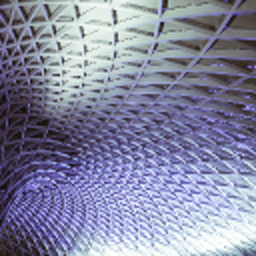

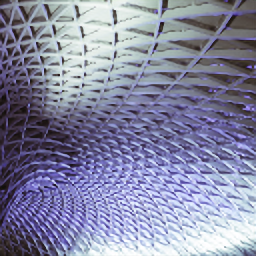

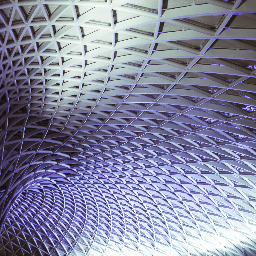

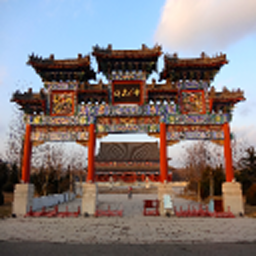

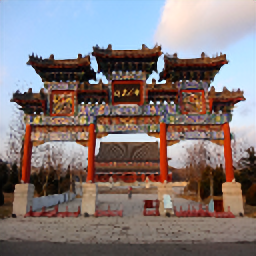

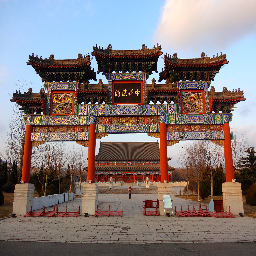

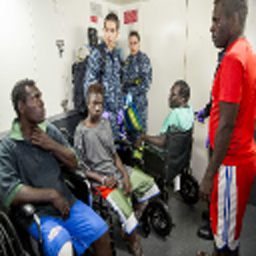

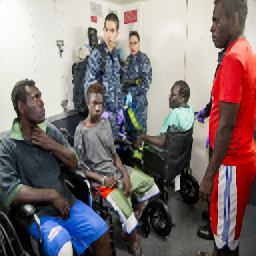

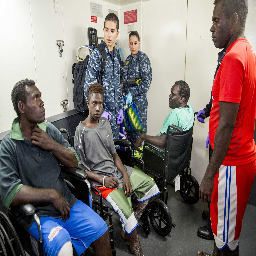

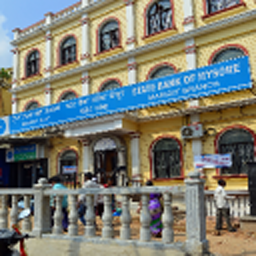

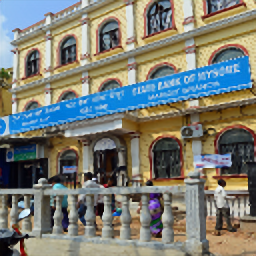

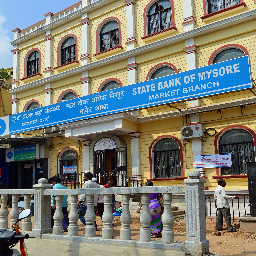

In [ ]:
model.load_weights('/content/drive/MyDrive/weights/resnet.h5')
img_lrs= val_data_generator[6][0]
img_hrs=val_data_generator[6][1]

outputs= model.predict(img_lrs)

for x in range(4):
  cv2_imshow(img_lrs[x])
  cv2_imshow(outputs[x])
  cv2_imshow(img_hrs[x])
